# Imports

In [1]:
import sys
sys.path.append("../src")

from dataset import ImageDataset, LABEL_NAME_DIC
from models import ResnetPredictor, train_epoch, val_epoch

import os.path as osp
import matplotlib.pyplot as plt
import numpy as np
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm

from sklearn.metrics import f1_score

DATA_PATH = "../imagenette"
DATA_SUMMARY = "noisy_imagenette.csv"

# Data

In [2]:
transform = transforms.Compose([transforms.CenterCrop(360), transforms.ToTensor()])

train_dataset = ImageDataset(osp.join(DATA_PATH, DATA_SUMMARY), transform, False)
val_dataset = ImageDataset(osp.join(DATA_PATH, DATA_SUMMARY), transform, True)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

device = "cuda" if torch.cuda.is_available() else "cpu"

model = ResnetPredictor().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Trained Classifier

In [ ]:
num_epoch = 10

train_losses = []
train_macrof1 = []
train_microf1 = []

val_losses = []
val_macrof1 = []
val_microf1 = []

for epoch in range(num_epoch):

    train_epoch_losses, train_epoch_macrof1, train_epoch_microf1 = train_epoch(
        train_dataloader, model, criterion, optimizer, device
    )
    train_losses.append(np.mean(train_epoch_losses))
    train_macrof1.append(train_epoch_macrof1)
    train_microf1.append(train_epoch_microf1)

    val_epoch_losses, val_epoch_macrof1, val_epoch_microf1 = val_epoch(
        val_dataloader, model, criterion, device
    )
    val_losses.append(np.mean(val_epoch_losses))
    val_macrof1.append(val_epoch_macrof1)
    val_microf1.append(val_epoch_microf1)

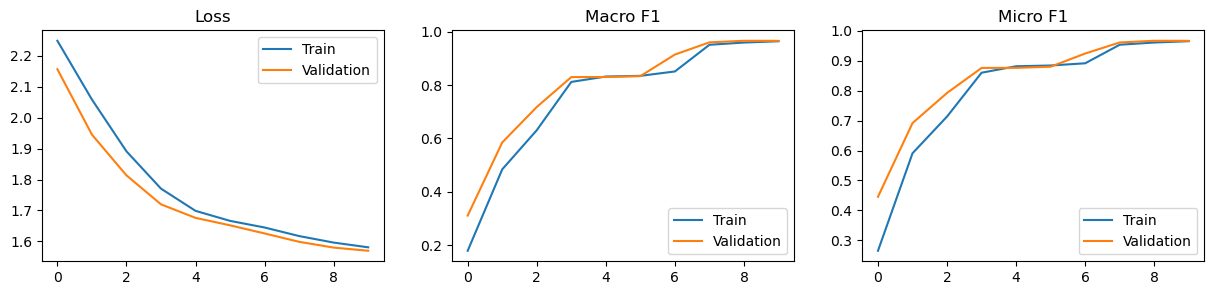

In [23]:
plt.figure(figsize=(15, 3))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label='Validation')
plt.title("Loss")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_macrof1, label="Train")
plt.plot(val_macrof1, label='Validation')
plt.title("Macro F1")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(train_microf1, label="Train")
plt.plot(val_microf1, label='Validation')
plt.title("Micro F1")
plt.legend()

plt.show()

In [21]:
torch.save(model.state_dict(), 'model_state_dict.pth')

In [4]:
model_state_dict = torch.load("model_state_dict.pth")

loaded_model = ResnetPredictor()
loaded_model.load_state_dict(model_state_dict)
loaded_model.eval()

toy_image_batch, toy_label_batch = next(iter(train_dataloader))
outputs = loaded_model(toy_image_batch)

pred_labels = torch.argmax(outputs, 1)
true_labels = torch.argmax(toy_label_batch, 1)

print(f"Macro F1 score: {f1_score(true_labels, pred_labels, average='macro')}")
print(f"Micro F1 score: {f1_score(true_labels, pred_labels, average='micro')}")

Macro F1 score: 0.9205152303836515
Micro F1 score: 0.921875


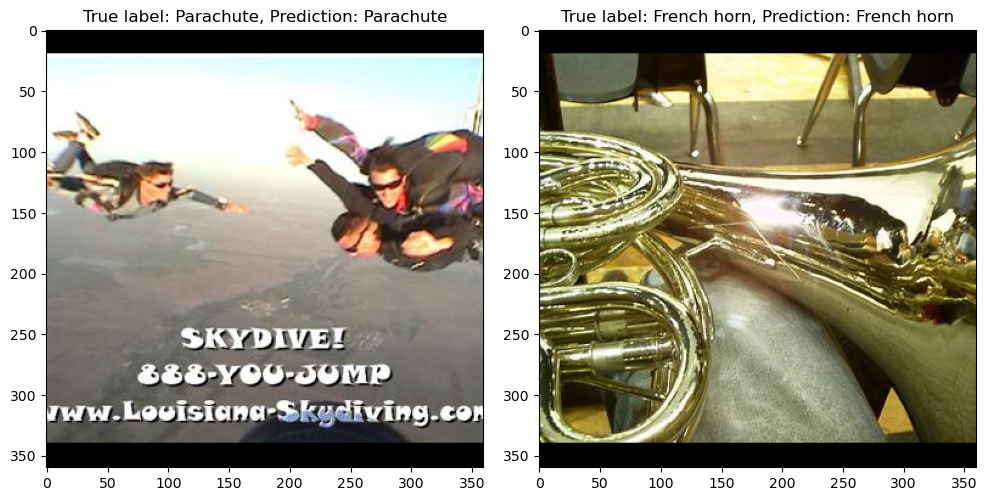

In [5]:
model_state_dict = torch.load("model_state_dict.pth")

loaded_model = ResnetPredictor()
loaded_model.load_state_dict(model_state_dict)
loaded_model.eval()

toy_image_1, toy_label_1 = train_dataset[random.randint(0, 8000)]
toy_image_2, toy_label_2 = train_dataset[random.randint(0, 8000)]

output_1 = loaded_model(toy_image_1.unsqueeze(0))
output_2 = loaded_model(toy_image_2.unsqueeze(0))

pred_label_1 = torch.argmax(output_1)
true_label_1 = torch.argmax(toy_label_1)

pred_label_2 = torch.argmax(output_2)
true_label_2 = torch.argmax(toy_label_2)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(np.transpose(toy_image_1.numpy(), (1, 2, 0)))
axs[0].set_title(
    f"True label: {LABEL_NAME_DIC[true_label_1.item()]}, Prediction: {LABEL_NAME_DIC[pred_label_1.item()]}"
)

axs[1].imshow(np.transpose(toy_image_2.numpy(), (1, 2, 0)))
axs[1].set_title(
    f"True label: {LABEL_NAME_DIC[true_label_2.item()]}, Prediction: {LABEL_NAME_DIC[pred_label_2.item()]}"
)

plt.tight_layout()
plt.show()